# Revisualizing CAPEC Data Model

The purpose of this notebook is to document research and analysis done on the Common Attack Pattern Enumeration and Classification (CAPEC) for the ultimate goal of creating a corpus for PERCEIVE. For more information on CAPEC, refer [CAPEC Introduction](https://github.com/sailuh/perceive/blob/master/Notebooks/CAPEC/capec_introduction.ipynb).

CAPEC displays its data in two formats: the [CAPEC Website](http://capec.mitre.org/) and the CAPEC XML file. The CAPEC 2.9 XML file used and its accompanying XML Schema Documentation are both available for download on the website [CAPEC website](http://capec.mitre.org/data/index.html) under "Release Downloads." 

The representation of the data on the [website](http://capec.mitre.org/data/definitions/1000.html) is easier to navigate and easier to make sense of than the XML file. The website's interface for the Views allows you to easily explore through the developed hierarchical relationships due to the (+) and (-) buttons that allow you to expand the relationships. However, as we need to revisualize the representation, we need to scrape the XML and obtain relevant information in order to plot an interactive Voronoi treemap using [Foamtree](https://carrotsearch.com/foamtree/).

The two Views are Mechanisms of Attack and Domains of Attack. Category Entries have *MemberOf* relationships to and are separated based on these views depending on whether they pertain to mechanisms employed in exploiting a vulnerability or the domains on which the attacks are perpetrated.

In [2]:
from IPython.display import Image
Image(filename='types_of_nodes_and_their_relationships_based_on_mechanisms_and_domains_of_attack_views.png')

Below Category Entries are the Attack Pattern Entries; It is important to note that there are three types of Attack Pattern Entries: Meta, Standard, and Detailed. These three terms refer to the level of abstraction in the particular Attack Pattern Entries.  

Meta Attack Pattern Entries are directly below Category Entries in the hierarchy and have the *MemberOf* relationship to these Categories. As the Categories are ways of sorting Attack Patterns, a given Meta Attack Pattern Entry will be a *MemberOf* two categories, one for each View. Meta Attack Pattern Entries have *Child* nodes that can be either Standard or Detailed Attack Patterns. These two abstraction types of Attack Patterns do not have a relationship to the Categories. Standard Attack Pattern Entries may also have their own Child, which will always be a Detailed Attack Pattern.

Given that Views and Categories are primarily methods of organizing Attack Patterns, we are specifically interested in the Attack Patterns and the Fields that they contain.

The challenge in extracting from the XML is that, while in the website, each Standard Attack Pattern is under a Meta Attack Pattern and each Meta Attack Pattern is in turn under a Category, the XML organization is not that simple.

The Categories are represented in the Categories table (or tag) of the XML and their titles are mentioned in attributes. Similarly, the Meta attack patterns are represented in the Attack Patterns table (or tag) of the XML and their titles are mentioned in attributes.

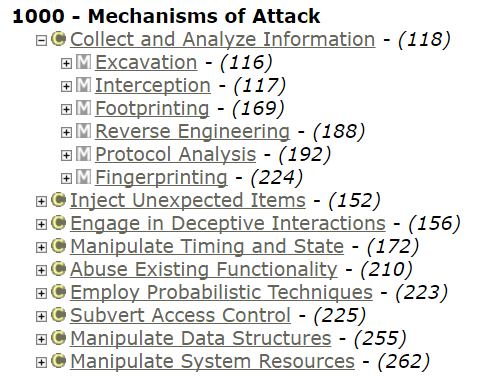

In [6]:
from IPython.display import Image
Image(filename='capec_website_representation.PNG')

The parent node of each attack pattern is mentioned via the Related Attack Patterns tag and the Relationship Target ID under it. The Relationship Nature is *ChildOf*.

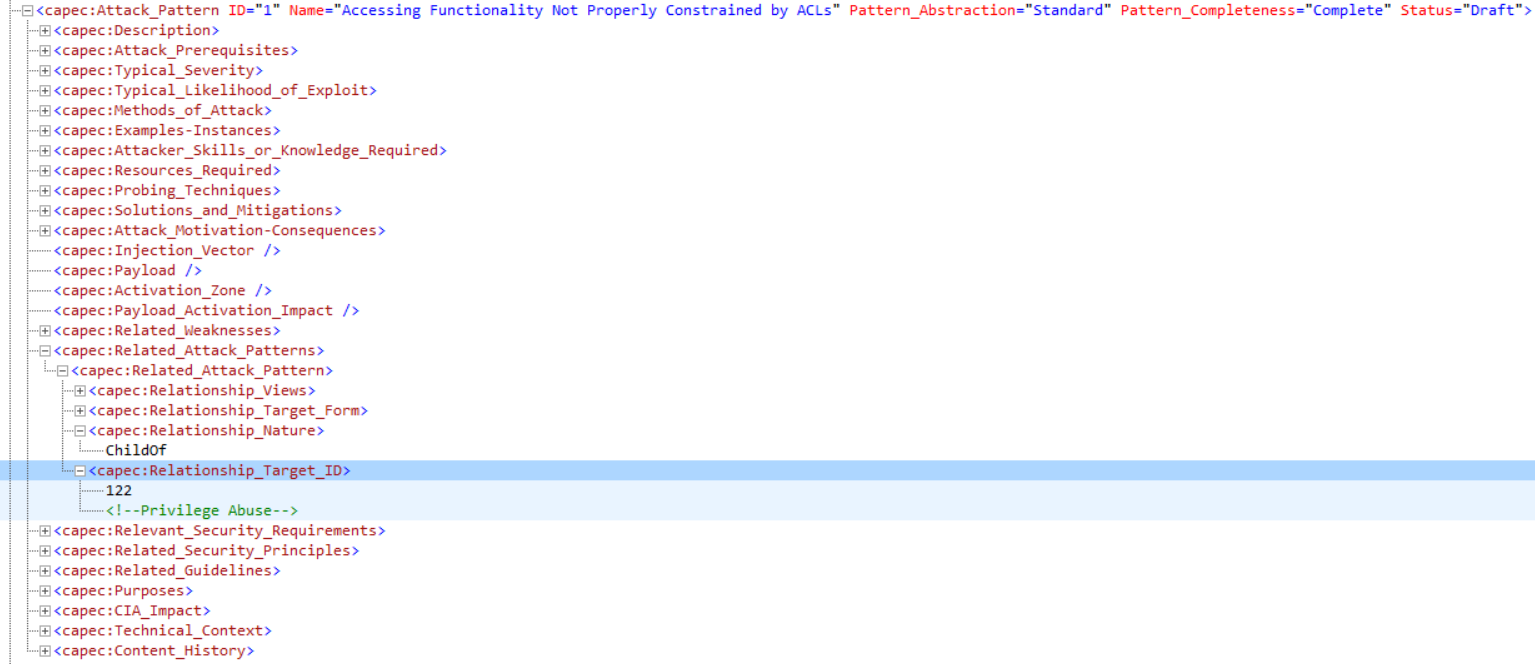

In [3]:
from IPython.display import Image
Image(filename='standard_attack_pattern_relationship.PNG')

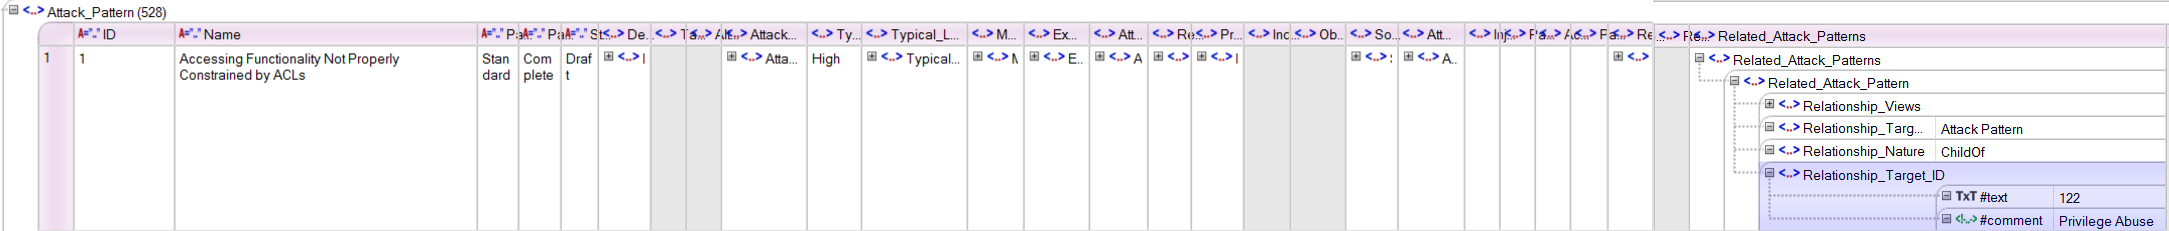

In [15]:
from IPython.display import Image
Image(filename='standard_attack_pattern_relationship_alt.PNG')

In the above images, the CAPEC ID 1 has its name under the **Name** attribute and is a _ChildOf_ CAPEC ID 122 through the Related_Attack_Pattern tag.

The implication is that the relationships of Meta attack patterns aren't mentioned in the Attack Patterns.

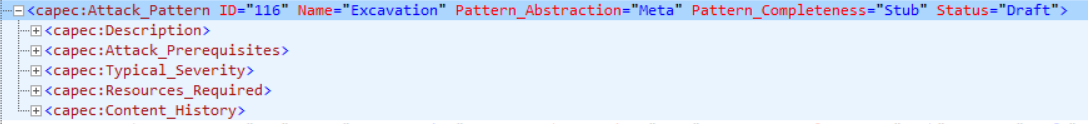

In [4]:
from IPython.display import Image
Image(filename='meta_attack_pattern_relationship_missing.PNG')

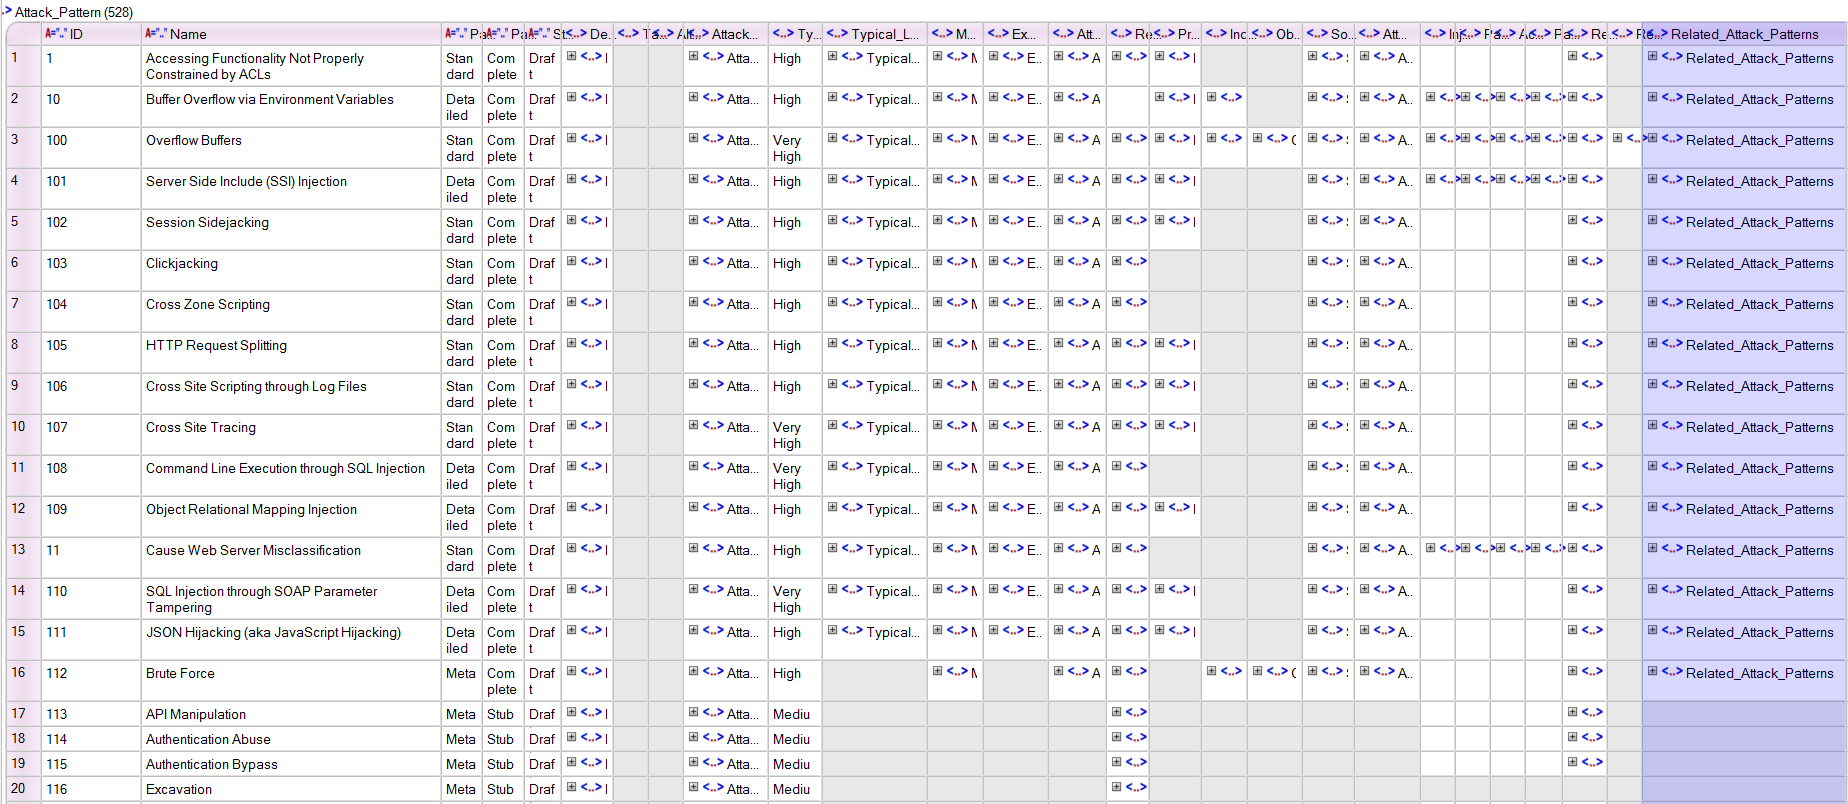

In [16]:
from IPython.display import Image
Image(filename='meta_attack_pattern_relationship_missing_alt.PNG')

From the above images, it is evident that Meta Attack Patterns such as CAPEC 116 - Excavation do not have any **Related_Attack_Patterns** under the Attack Pattern Table (or tag).

These relationships are under Categories but not as *ChildOf* relationship nature, but in the other way around. The Meta Attack Patterns are included as *HasMember* relationship type under the main Category

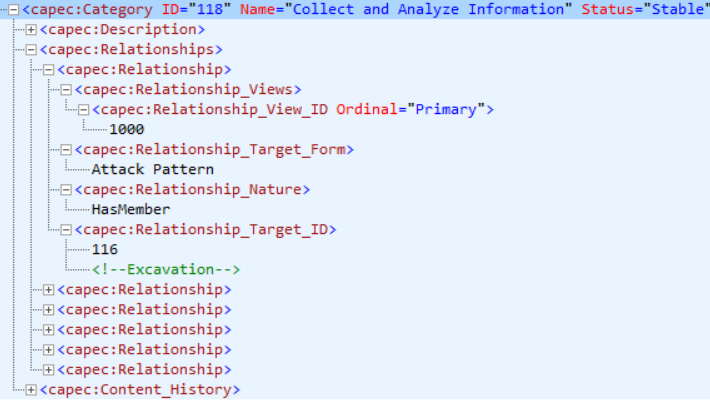

In [5]:
from IPython.display import Image
Image(filename='meta_attack_pattern_relationship.PNG')

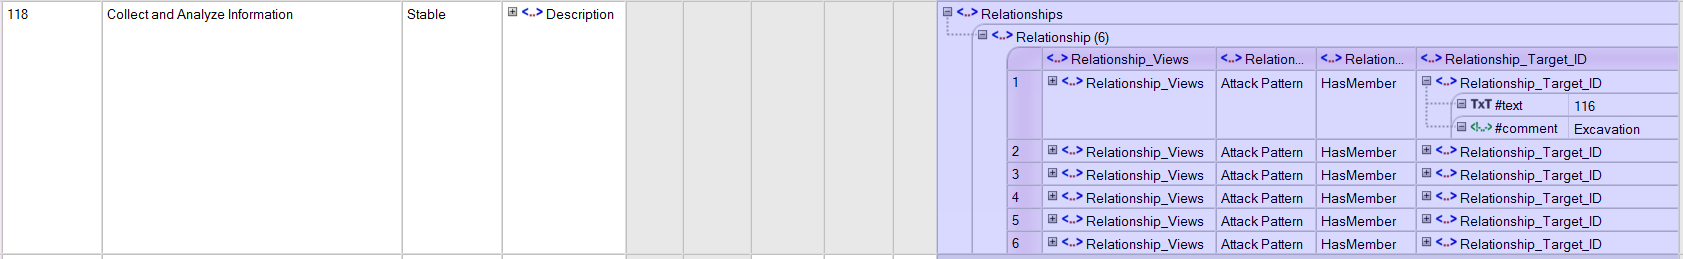

In [17]:
from IPython.display import Image
Image(filename='meta_attack_pattern_relationship_alt.PNG')

These images indicate that the relationships of each Meta Attack Pattern is under the Categories table, nested under each Category not as a _ChildOf_ relationship but as a _HasMember_ relationship.

# Parsing the XML File

Since the child node parent node relationship is convoluted in the XML, we must first bring them to a uniform format. The following python script has three logical blocks and takes as input two parameters:

1. path of the CAPEC XML file.
2. path of the Foamtree JavaScript file.

The first part of the program creates a CSV file which contains **CAPEC_ID, CAPEC_NAME, CHILD_OF** columns and parses the XML to populate various categories, meta attack patterns and their child standard attack patterns.

The second part involves parsing this CSV file to a JSON object that can be used for the Foamtree visualization. The JSON is then fed into the dataObject variable in the JavaScript and hence must follow the [standards](https://get.carrotsearch.com/foamtree/latest/api/index.html#dataObject) set by Foamtree.

The final part involves putting together the JavaScript file whose path has been obtained as input 2 in a HTML file and then adding the JSON data into the dataObject variable in the JavaScript to obtain the final visualization.

The program exports the following files:

1. CAPEC_csv
2. CAPEC_json
3. CAPEC_html

In [14]:
import os
import sys

import csv
import xml.etree.ElementTree as ET

import json

#Input obtained from the user
xml_path = sys.argv[1]
javascript_path = sys.argv[2]

#Obtaining the CAPEC xml filename from the path
CAPEC_xml = xml_path.split(os.sep)[-1]

#Obtaining the CAPEC version from the filename and using it to rename other files
CAPEC_version = CAPEC_xml[:-4]
CAPEC_json = CAPEC_version + ".json"
CAPEC_csv = CAPEC_version + ".csv"
CAPEC_html = CAPEC_version + ".html"

CAPEC_tree = ET.parse(xml_path)
CAPEC_root = CAPEC_tree.getroot()

#The purpose of this function is to remove the commas in the string that is passed as input. The need is that some of the CAPEC 
#names contain commas and when added to a CSV file, they occupy multiple cells instead of just one. In order to overcome that we
#pass the CAPEC name and obtain the "comma-less" version of it.
def remove_commas(string):
    comma_free_string = ''
    temp_string = string.split(',')
    for i in temp_string:
        comma_free_string+=i
    return comma_free_string

#The CSV file is created and various columns named
f = open(CAPEC_csv, 'w')
HEAD = "CAPEC_ID, CAPEC_NAME, CHILD_OF\n"
f.write(HEAD)

#There are three for loops which write to the CSV file. 

#The first one is used to write the categories with parent as 1000 - Mechanisms of Attack
#CAPEC_root[0][0] is used to obtain capec:Views and then under it the first tag that contains Mechanisms of attack categories
for division in CAPEC_root[0][0]:
    for parameter in division:
        if parameter.tag=="{http://capec.mitre.org/capec-2}Relationship":
            capec_id = parameter[3].text
            child_of = '1000'
                
#After obtaining the capec_id, we search for the name in the capec:Categories which is CAPEC_root[1] 
            for category in CAPEC_root[1]:
                if category.attrib['ID']==capec_id:
                capec_name = remove_commas(category.attrib['Name'])
                vuln = '{o1},{o2},{o3}\n'.format(o1=capec_id,o2=capec_name,o3=child_of)
                f.write(vuln)

#The second one is used to write the Meta Attack Patterns onto the CSV
#CAPEC_root[1] is used to obtain the capec:Categories tag.
for attack_pattern in CAPEC_root[1]:
    if attack_pattern.attrib['Status']!="Deprecated":
        for parameter in attack_pattern:
            if parameter.tag=="{http://capec.mitre.org/capec-2}Relationships":
                for relationship_parameter in parameter:
                    
#relationship_parameter[2] is capec:Relationship_Nature
                    if relationship_parameter[2].text=="HasMember":
                        
#As mentioned above, this is the part where the child and parent relationship is inversed. We therefore
#take the attack pattern's ID in the Child_of variable.
                        child_of = attack_pattern.attrib['ID']

#relationship_parameter[3] is capec:Relationship_Target_ID
                        capec_id= relationship_parameter[3].text 
                        
#From the capec_id that we obtained, we search for it in capec:Attack_Patterns which is CAPEC_root[2]
                        for attack_pattern_matcher in CAPEC_root[2]:
                            if attack_pattern_matcher.attrib['ID']==capec_id:
                                capec_name= remove_commas(attack_pattern_matcher.attrib['Name'])
                        vuln = '{o1},{o2},{o3}\n'.format(o1=capec_id,o2=capec_name,o3=child_of)
                        f.write(vuln)

#The third and final loop is used to add the Standard Attack Patterns onto the CSV
#CAPEC_root[2] is used to select capec:Attack_Patterns
for attack_pattern in CAPEC_root[2]:
    if attack_pattern.attrib['Status']!="Deprecated":
        for parameter in attack_pattern:
            if parameter.tag=="{http://capec.mitre.org/capec-2}Related_Attack_Patterns":
                for related_attack_pattern_parameter in parameter:
                    if related_attack_pattern_parameter[2].text=="ChildOf":
                        capec_id= attack_pattern.attrib['ID']
                        capec_name= remove_commas(attack_pattern.attrib['Name'])
                        child_of= related_attack_pattern_parameter[3].text
                        vuln = '{o1},{o2},{o3}\n'.format(o1=capec_id,o2=capec_name,o3=child_of)
                        f.write(vuln)

f.close()

IndentationError: expected an indented block (<ipython-input-14-47a2a9707811>, line 53)

The CSV generated at this point looks like:

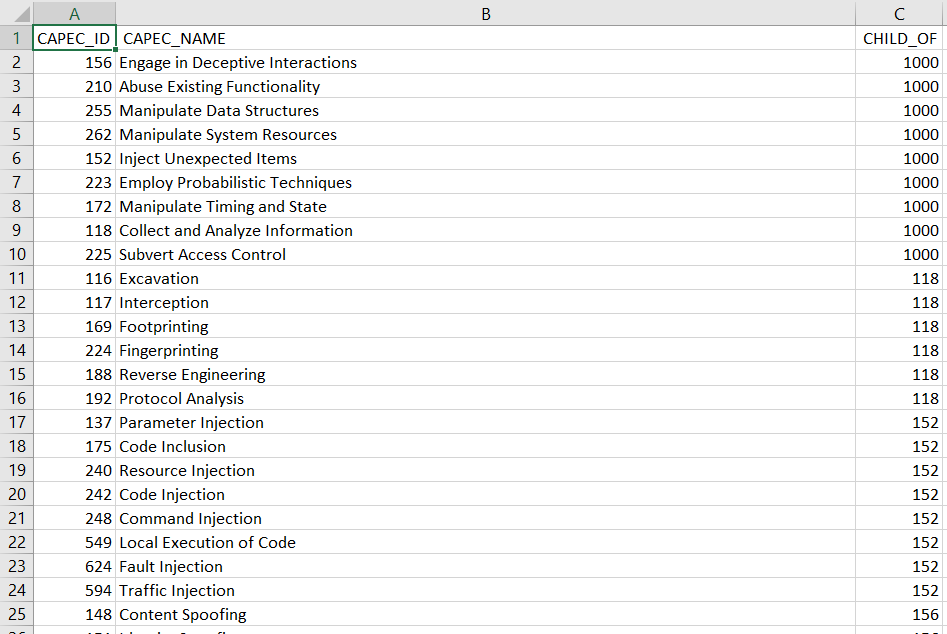

In [18]:
from IPython.display import Image
Image(filename='sample_csv.PNG')

In [ ]:
#This is the second logical block of the program wherein the CSV is parsed to build the JSON
#We convert the CSV to a list of lists
CAPEC_csv = open(CAPEC_csv, 'rb')
csv_row_list = list()
for row in CAPEC_csv:
    row_list = row.split(',')
    csv_row_list.append(row_list)

#This iterative function is used to build the JSON in the format that foamtree javascript requires. 
def jsonify(number):
    main_list = list()
    for row in csv_row_list:
        parent_id = str(number)+'\n'
        
#each row in the CSV will contain its parent_id in the row[2] element
        if row[2]==parent_id:
            member_dict = dict()
            
#member_dict["label"] is used to name each element in the representation. The current naming scheme is 
#<CAPEC_ID> - <CAPEC_NAME>
            member_dict["label"] = str(row[0]) + ' - ' + str(row[1])
            member_dict["weight"] = 1
            member_dict["groups"] = jsonify(row[0])
            main_list.append(member_dict)
        else:
            continue
    return main_list

CAPEC_dict = dict()

#jsonify(1000) starts with Mechanisms of Attack and iterates through each Category recursively
CAPEC_dict["groups"]=jsonify(1000)

#Exporting the JSON
with open(CAPEC_json,'w') as jsonfile:
    json.dump(CAPEC_dict, jsonfile)

CAPEC_csv.close()
jsonfile.close()

The JSON objected created follows the [following rules](https://get.carrotsearch.com/foamtree/latest/api/index.html#dataObject) which requires a format such as:

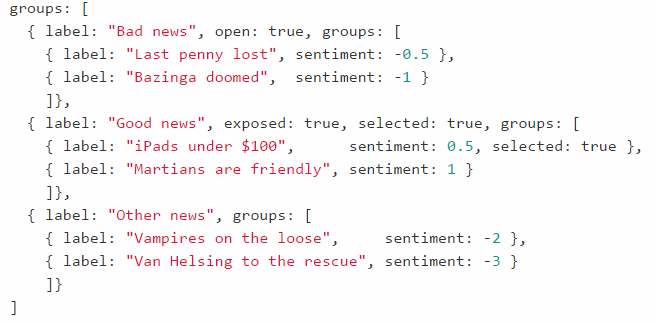

In [19]:
from IPython.display import Image
Image(filename='expected_json.PNG')

The JSON that we export looks like this:

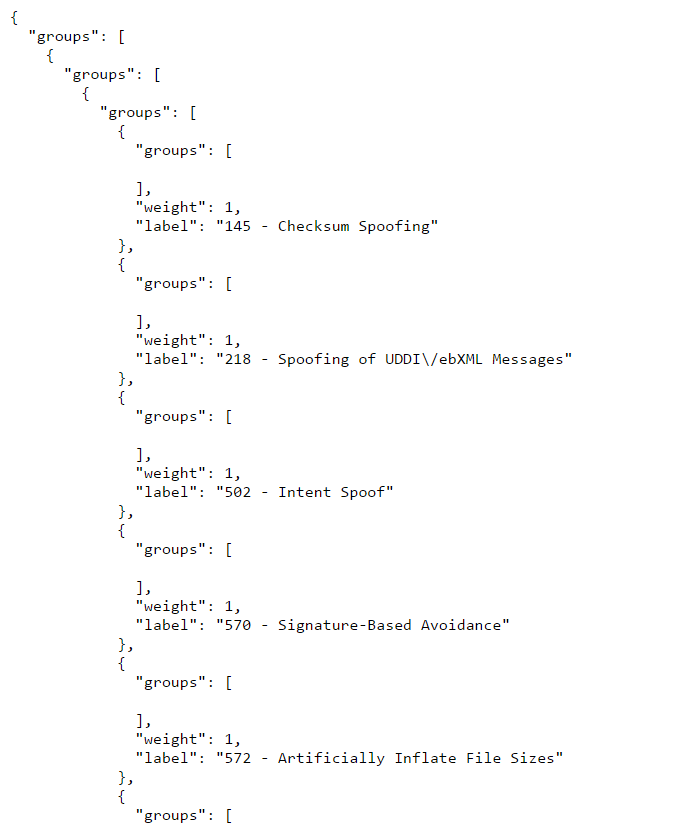

In [20]:
from IPython.display import Image
Image(filename='sample_json.PNG')

In [ ]:
#This is the final part of the program wherein we build the HTML to visualize the JSON using Foamtree javascript
#foamtreetemplate1 and foamtreetemplate2 are part of the final HTML visualization file
foamtreetemplate1 = '''<!DOCTYPE html>
<html>
  <head>
    <title>FoamTree Quick Start</title>
    <meta charset="utf-8" />
  </head>

  <body>
    <div id="visualization" style="width: 800px; height: 600px"></div>

    <script src="'''+ javascript_path +'''"></script>
    <script>
      window.addEventListener("load", function() {
        var foamtree = new CarrotSearchFoamTree({
          id: "visualization",
          dataObject:'''

foamtreetemplate2 = '''});
      });
    </script>
  </body>
</html>'''

with open(CAPEC_html,'w') as outputfile:
    outputfile.write(foamtreetemplate1)
    for line in open(CAPEC_json):
        outputfile.write(line)
    outputfile.write(foamtreetemplate2)

The final HTML export looks like this (CAPEC v2.9): 

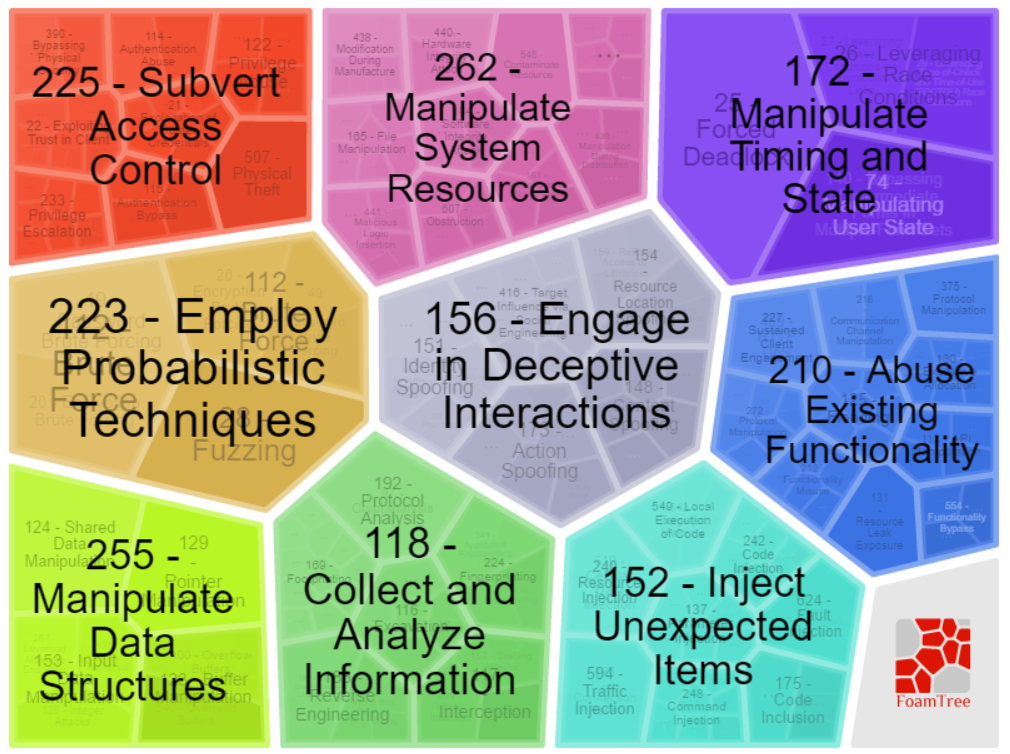

In [23]:
from IPython.display import Image
Image(filename='sample_html.PNG')

# Differences between CAPEC v2.8 and v2.9

The following categories were modified as mentioned in [CAPEC Difference Report]( https://capec.mitre.org/data/reports/diff_reports/v2.8_v2.9.html).

- CAPEC-118	Collect and Analyze Information
- CAPEC-152	Inject Unexpected Items
- CAPEC-156	Engage in Deceptive Interactions
- CAPEC-172	Manipulate Timing and State
- CAPEC-210	Abuse Existing Functionality
- CAPEC-223	Employ Probabilistic Techniques
- CAPEC-225	Subvert Access Control
- CAPEC-255	Manipulate Data Structures
- CAPEC-262	Manipulate System Resources
- CAPEC-339	WASC-06 - Format String
- CAPEC-340	WASC-07 - Buffer Overflow
- CAPEC-343	WASC-10 - Denial of Service
- CAPEC-378	WASC-45 - Fingerprinting
- CAPEC-512	Communications
- CAPEC-513	Software

Some categories were deprecated such as

- CAPEC-119	Deplete Resources
- CAPEC-232	Exploitation of Authorization
- CAPEC-281	Analyze Target
- CAPEC-436	Gain Physical Access
- CAPEC-525	Execute Code
- CAPEC-526	Alter System Components
- CAPEC-527	Manipulate System Users

If a category is deprecated, the meta attack patterns under it are reorganized under another category. 

For example, let us consider a deprecated category such as CAPEC-119 Deplete Resources which had the following meta attack patterns:

- CAPEC-125	Flooding
- CAPEC-130	Excessive Allocation
- CAPEC-131	Resource Leak Exposure
- CAPEC-227	Sustained Client Engagement
- CAPEC-490	Amplification

After its deprecation, these meta attack patterns have been added to CAPEC 513 – Software which does not come under Mechanisms of Attack. This does not mean that all the meta attack patterns under deprecated categories will not be represented in the Mechanisms of Attack view, as in the case of CAPEC-232 Exploitation of Authorization, its meta attack patterns were added to CAPEC-225 – Subvert Access Control.

On further analysis the meta attack patterns under CAPEC-119, CAPEC-281, CAPEC-525, CAPEC-526 and CAPEC-527 have moved to the Domains of attack view from the Mechanisms of Attack view.